In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

import os

In [2]:
base_path = os.path.expanduser('~/SSS_mount/insituCNV/InSituCNV/Figure2/01_Simulate_CNVs_in_spatial_data/01_Load_Xenium_5K_lymph_data/Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs')

cell_feature_matrix_h5 = os.path.join(base_path, 'cell_feature_matrix.h5')
cells_csv = os.path.join(base_path, 'cells.csv.gz')

# Create an AnnData object

In [3]:
adata = sc.read_10x_h5(cell_feature_matrix_h5)

## Add the cell information

In [4]:
cell_info = pd.read_csv(cells_csv, index_col=0)
cell_info.head()

,x_centroid,y_centroid,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method
cell_id,,,,,,,,,,,,,
aaaaadoa-1,2871.859619,347.729767,271,0,0,0,0,0,271,87.332191,46.646408,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaaaclhf-1,2882.301025,349.938110,315,0,0,0,0,0,315,43.530627,21.900782,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaaafcfj-1,2880.217041,338.575897,337,0,0,0,0,0,337,58.206408,27.996876,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaaagamp-1,2852.795166,356.880615,235,0,0,0,0,0,235,34.273595,23.120001,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaaaiako-1,2854.036133,361.754639,102,0,0,0,0,0,102,19.823594,NaN,0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...


In [5]:
cell_info.set_index(adata.obs_names, inplace=True)
adata.obs = cell_info.copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 708983 × 4624
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method'
    var: 'gene_ids', 'feature_types', 'genome'

## Add cell types

In [7]:
cell_type_path = os.path.expanduser("~/SSS_mount/insituCNV/InSituCNV/Figure2/01_Simulate_CNVs_in_spatial_data/01_Load_Xenium_5K_lymph_data/Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_cell_types.csv")
cell_types = pd.read_csv(cell_type_path, index_col=0)
cell_types.head()

,group
cell_id,
aaaaadoa-1,Endothelial Cell
aaaaclhf-1,CD4+ αβ Memory T Cell
aaaafcfj-1,Hematopoietic Stem Cell
aaaagamp-1,Innate Lymphoid Cell
aaaaiako-1,Innate Lymphoid Cell


In [8]:
cell_types.set_index(adata.obs_names, inplace=True)

In [9]:
adata.obs = adata.obs.join(cell_types, how='left')

## Add the spatial coordinates into an obsm

In [10]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [11]:
adata

AnnData object with n_obs × n_vars = 708983 × 4624
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'group'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

# QC

In [12]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [13]:
adata

AnnData object with n_obs × n_vars = 708983 × 4624
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

In [14]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.0005167418062654865
Negative decoding count % : 0.0004717166843416448


<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

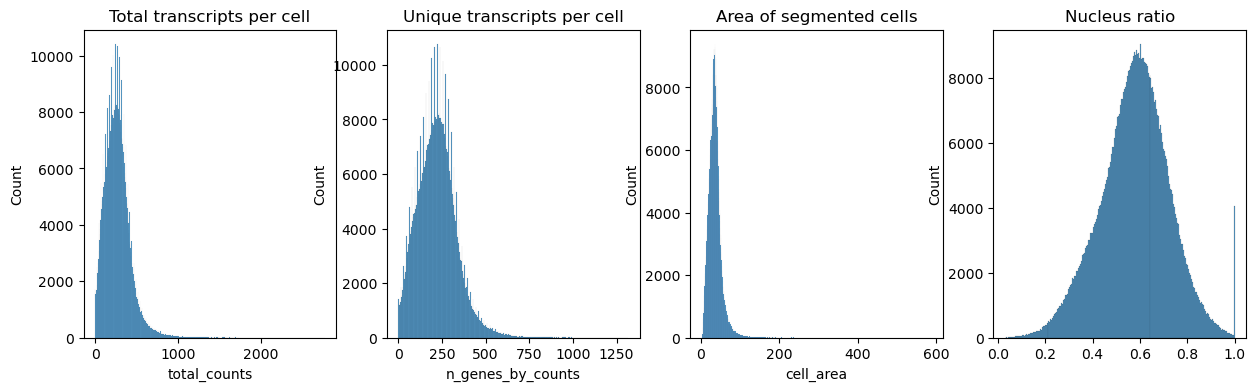

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

In [16]:
# sc.pp.filter_cells(adata, min_counts=10)
# sc.pp.filter_genes(adata, min_cells=5)

In [17]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
IOStream.flush timed out
/tmp/ipykernel_1065952/4193936636.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [18]:
adata

AnnData object with n_obs × n_vars = 708983 × 4624
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

# Visualize annotation on UMAP and spatial coordinates

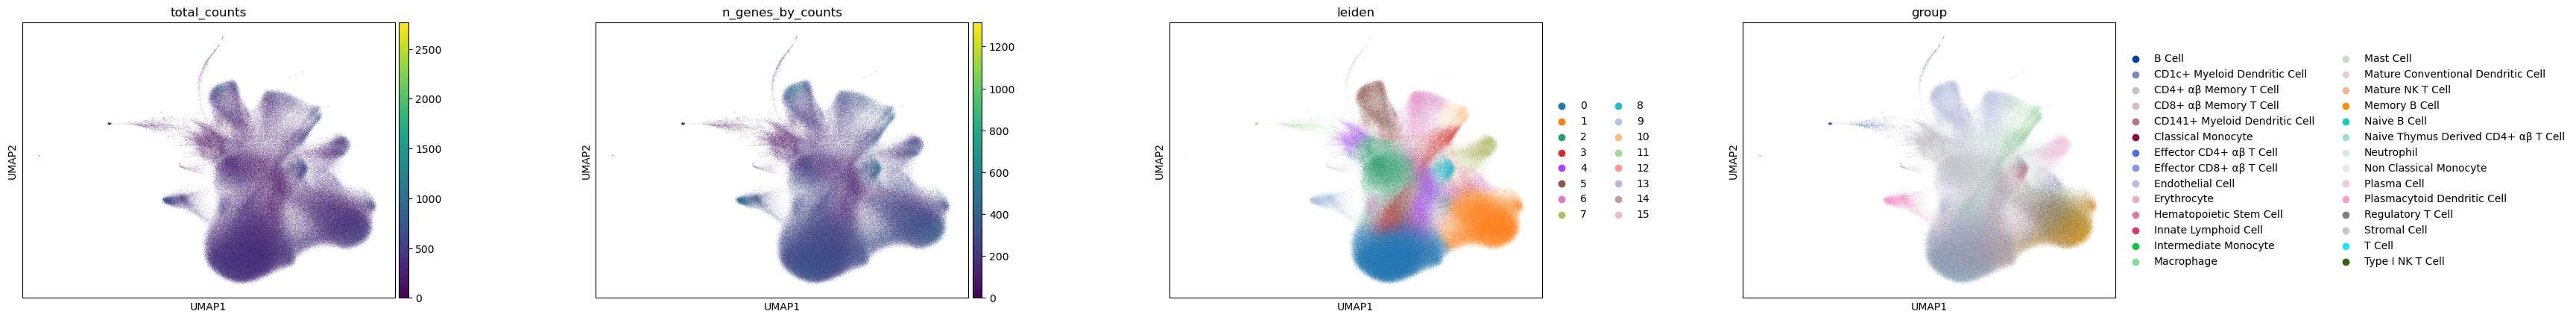

In [19]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
        "group"
    ],
    wspace=0.4,
)

/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


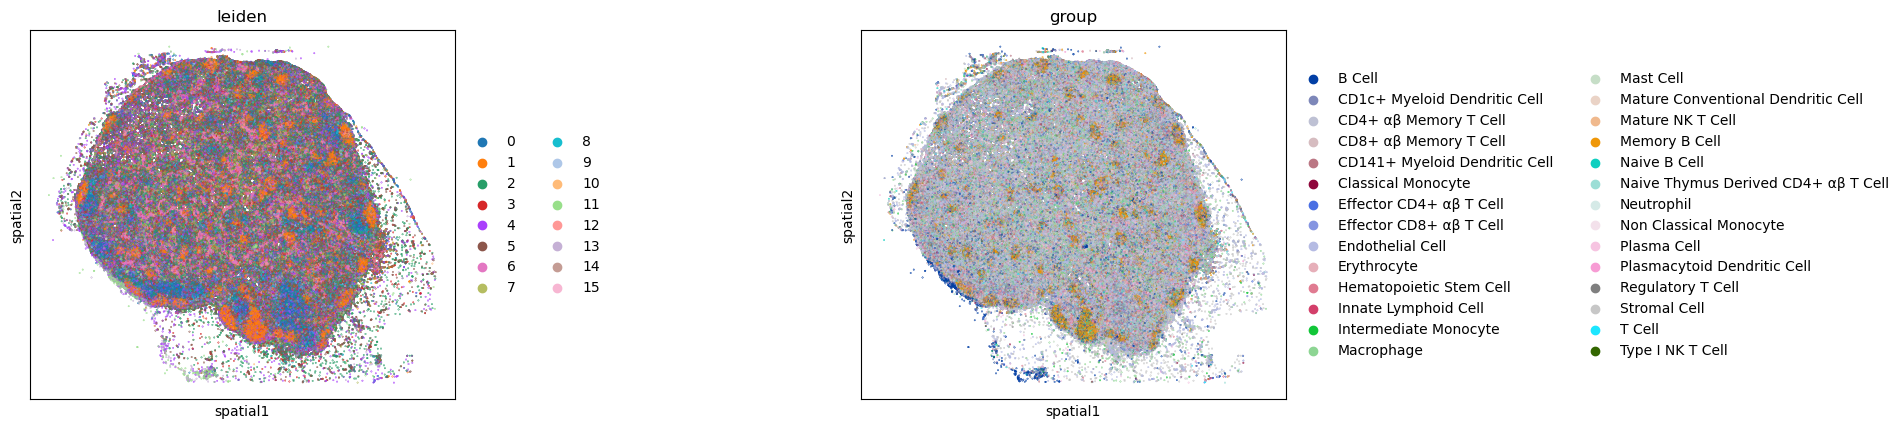

In [20]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden", 'group'
    ],
    wspace=0.4,
)

In [21]:
adata

AnnData object with n_obs × n_vars = 708983 × 4624
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'group_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

# Add chromosomal positions to the genes

In [22]:
import sys
sys.path.append('/home/augusta/SSS_mount/insituCNV/InSituCNV/modules')

In [23]:
sys.path

['/home/augusta/SSS_mount/insituCNV/InSituCNV/Figure2/01_Simulate_CNVs_in_spatial_data/01_Load_Xenium_5K_lymph_data',
 '/home/augusta/SSS_mount/mymodules',
 '/home/augusta/anaconda3/envs/scanpy_env/lib/python312.zip',
 '/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12',
 '/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12/lib-dynload',
 '',
 '/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12/site-packages',
 '/home/augusta/SSS_mount/mymodules',
 '/home/augusta/SSS_mount/insituCNV/InSituCNV']

In [24]:
import modify_anndata as ma

# Change so that the ensmbl IDs are the variable names
adata.var['gene_names'] = adata.var_names
adata.var_names = adata.var['gene_ids']

# Add genomic positions
ma.add_genomic_positions(adata=adata)

#Change back so that the gene names are the variable names again
adata.var_names = adata.var['gene_names']

4425 gene positions identified 
199 were not found


# Save data as AnnData object 

In [25]:
adata.write_h5ad("Xenium_HumanLymphNode_5K.h5ad", compression = 'gzip')